In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np

import tensorflow as tf
from tensorflow.python import tf2
if not tf2.enabled():
    import tensorflow.compat.v2 as tf
    tf.enable_v2_behavior()
    assert tf2.enabled()

# import tensorflow_datasets as tfds
import tensorflow_probability as tfp

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

from tensorflow.keras.utils import plot_model

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn import preprocessing
import os

%matplotlib inline
np.random.seed(0)
tf.random.set_seed(0)
print(tf.__version__)
print(tfp.__version__)

2.2.0
0.10.0


In [2]:
### Utility Functions
## Plots
# Plot Feature Projection [credit: https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders]
def tsne_plot(x1, y1, name="graph.png"):
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)

    # plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Normal', s=2)
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Attack', s=2)

    plt.legend(loc='best');
    plt.savefig(name);
    plt.show();
    
# Plot Keras training history
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.yscale('log',basey=10)
    plt.show()

In [3]:
df = pd.read_csv("C:/Users/Ruben/Datasets/WADI/WADI_attackdataLABLE.csv", low_memory=False)

df.columns = [
    'ROW','DATE','TIME','1_AIT_001_PV','1_AIT_002_PV','1_AIT_003_PV','1_AIT_004_PV','1_AIT_005_PV','1_FIT_001_PV','1_LS_001_AL',
    '1_LS_002_AL','1_LT_001_PV','1_MV_001_STATUS','1_MV_002_STATUS','1_MV_003_STATUS','1_MV_004_STATUS','1_P_001_STATUS',
    '1_P_002_STATUS','1_P_003_STATUS','1_P_004_STATUS','1_P_005_STATUS','1_P_006_STATUS','2_DPIT_001_PV','2_FIC_101_CO',
    '2_FIC_101_PV','2_FIC_101_SP','2_FIC_201_CO','2_FIC_201_PV','2_FIC_201_SP','2_FIC_301_CO','2_FIC_301_PV','2_FIC_301_SP',
    '2_FIC_401_CO','2_FIC_401_PV','2_FIC_401_SP','2_FIC_501_CO','2_FIC_501_PV','2_FIC_501_SP','2_FIC_601_CO','2_FIC_601_PV',
    '2_FIC_601_SP','2_FIT_001_PV','2_FIT_002_PV','2_FIT_003_PV','2_FQ_101_PV','2_FQ_201_PV','2_FQ_301_PV','2_FQ_401_PV',
    '2_FQ_501_PV','2_FQ_601_PV','2_LS_001_AL','2_LS_002_AL','2_LS_101_AH','2_LS_101_AL','2_LS_201_AH','2_LS_201_AL',
    '2_LS_301_AH','2_LS_301_AL','2_LS_401_AH','2_LS_401_AL','2_LS_501_AH','2_LS_501_AL','2_LS_601_AH','2_LS_601_AL',
    '2_LT_001_PV','2_LT_002_PV','2_MCV_007_CO','2_MCV_101_CO','2_MCV_201_CO','2_MCV_301_CO','2_MCV_401_CO','2_MCV_501_CO',
    '2_MCV_601_CO','2_MV_001_STATUS','2_MV_002_STATUS','2_MV_003_STATUS','2_MV_004_STATUS','2_MV_005_STATUS','2_MV_006_STATUS',
    '2_MV_009_STATUS','2_MV_101_STATUS','2_MV_201_STATUS','2_MV_301_STATUS','2_MV_401_STATUS','2_MV_501_STATUS',
    '2_MV_601_STATUS','2_P_001_STATUS','2_P_002_STATUS','2_P_003_SPEED','2_P_003_STATUS','2_P_004_SPEED','2_P_004_STATUS',
    '2_PIC_003_CO','2_PIC_003_PV','2_PIC_003_SP','2_PIT_001_PV','2_PIT_002_PV','2_PIT_003_PV','2_SV_101_STATUS',
    '2_SV_201_STATUS','2_SV_301_STATUS','2_SV_401_STATUS','2_SV_501_STATUS','2_SV_601_STATUS','2A_AIT_001_PV','2A_AIT_002_PV',
    '2A_AIT_003_PV','2A_AIT_004_PV','2B_AIT_001_PV','2B_AIT_002_PV','2B_AIT_003_PV','2B_AIT_004_PV','3_AIT_001_PV',
    '3_AIT_002_PV','3_AIT_003_PV','3_AIT_004_PV','3_AIT_005_PV','3_FIT_001_PV','3_LS_001_AL','3_LT_001_PV','3_MV_001_STATUS',
    '3_MV_002_STATUS','3_MV_003_STATUS','3_P_001_STATUS','3_P_002_STATUS','3_P_003_STATUS','3_P_004_STATUS','LEAK_DIFF_PRESSURE',
    'PLANT_START_STOP_LOG','TOTAL_CONS_REQUIRED_FLOW','OUTCOME'
]

df = df.iloc[1:] # Row only contains labels
df = df.drop([172802,172803]) # Rows contain no information, only nan values

# 'ROW', 'DATE' and 'TIME' are irrelevant for the thesis.
# '2_LS_001_AL', '2_LS_002_AL', '2_P_001_STATUS', '2_P_002_STATUS' contain only nan values
# Other dropped columns contain either only 0s, only 1s or only 2s and are therefore irrelevant

df = df.drop(['ROW', 'DATE', 'TIME', '1_LS_001_AL', '1_LS_002_AL', '1_P_002_STATUS', '1_P_004_STATUS', '2_LS_001_AL', 
              '2_LS_002_AL', '2_MV_001_STATUS', '2_MV_002_STATUS', '2_MV_004_STATUS', '2_MV_005_STATUS', '2_MV_009_STATUS',
              '2_P_001_STATUS', '2_P_002_STATUS', '2_P_004_STATUS', '2_SV_101_STATUS', '2_SV_201_STATUS', '2_SV_301_STATUS',
              '2_SV_401_STATUS', '2_SV_501_STATUS', '2_SV_601_STATUS', '3_AIT_001_PV', '3_LS_001_AL', '3_MV_001_STATUS',
              '3_MV_002_STATUS', '3_MV_003_STATUS', '3_P_001_STATUS', '3_P_002_STATUS', '3_P_003_STATUS', '3_P_004_STATUS',
              'PLANT_START_STOP_LOG'], axis = 1)

# set OUTCOME data type to int and change normal values to 0 / attack values to -1 
df['OUTCOME'] = df['OUTCOME'].astype(int)
df['OUTCOME'].replace(to_replace = [1], value = 0, inplace = True)
df['OUTCOME'].replace(to_replace = [-1], value = 1, inplace = True)

# data types need to be numeric to be encoded to z-scores --> convert column object data types to numerics
cols = df.columns[df.columns != 'OUTCOME']
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Encoding the feature vectors to z-scores
cols = list(df.columns[df.columns != 'OUTCOME'])
for col in cols:
    df[col] = ((df[col] - df[col].mean())/df[col].std(ddof=0))

In [ ]:
# define a method to scale data, looping thru the columns, and passing a scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(-1,1))
cols = list(df.columns[df.columns != 'OUTCOME'])
for col in cols:
    df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))

In [ ]:
# df = df.drop(['1_AIT_001_PV','1_AIT_002_PV','1_AIT_003_PV','1_AIT_004_PV','1_AIT_005_PV','1_FIT_001_PV',
#     '1_LT_001_PV','1_MV_001_STATUS','1_MV_002_STATUS','1_MV_003_STATUS','1_MV_004_STATUS','1_P_001_STATUS','1_P_003_STATUS',
#     '1_P_005_STATUS','1_P_006_STATUS','2_DPIT_001_PV','2_FIC_101_CO',
#     '2_FIC_101_PV','2_FIC_101_SP','2_FIC_201_CO','2_FIC_201_PV','2_FIC_201_SP','2_FIC_301_CO','2_FIC_301_PV','2_FIC_301_SP',
#     '2_FIC_401_CO','2_FIC_401_PV','2_FIC_401_SP','2_FIC_501_CO','2_FIC_501_PV','2_FIC_501_SP','2_FIC_601_CO','2_FIC_601_PV',
#     '2_FIC_601_SP','2_FIT_001_PV','2_FIT_002_PV','2_FIT_003_PV','2_FQ_101_PV','2_FQ_201_PV','2_FQ_301_PV','2_FQ_401_PV',
#     '2_FQ_501_PV','2_FQ_601_PV','2_LS_101_AH','2_LS_101_AL','2_LS_201_AH','2_LS_201_AL',
#     '2_LS_301_AH','2_LS_301_AL','2_LS_401_AH','2_LS_401_AL','2_LS_501_AH','2_LS_501_AL','2_LS_601_AH','2_LS_601_AL',
#     '2_LT_001_PV','2_LT_002_PV','2_MCV_007_CO','2_MCV_101_CO','2_MCV_201_CO','2_MCV_301_CO','2_MCV_401_CO','2_MCV_501_CO',
#     '2_MCV_601_CO','2_MV_003_STATUS','2_MV_006_STATUS','2_MV_101_STATUS'], axis = 1)

In [ ]:
df.describe()

In [ ]:
print(df.shape)
df.head(150)

In [ ]:
df, data_test = train_test_split(df, test_size=0.25)

In [4]:
attack = df[df['OUTCOME'] == 1]
print(attack.shape)

(9977, 98)


In [5]:
normal = df[df['OUTCOME'] == 0].sample(9900)
attack = df[df['OUTCOME'] == 1].sample(9900)

df1 = normal.append(attack).sample(frac=1).reset_index(drop=True)

X = df1.drop(['OUTCOME'], axis = 1).values
Y = df1["OUTCOME"].values

# tsne_plot(X, Y, "TSNE_WADI.png")

In [6]:
print(X.shape)
print(X.shape[1])
print(X[0].shape)
print(Y.shape)

(19800, 97)
97
(97,)
(19800,)


In [ ]:
# def dense_layers(sizes):
#     return tfk.Sequential([tfkl.Dense(size, activation=tf.nn.leaky_relu) for size in sizes])

# original_dim = X.shape[1]
# input_shape = X[0].shape
# intermediary_dims = [80, 60, 50]
# latent_dim = 2
# batch_size = 128
# max_epochs = 1000

# # prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1),
# #                         reinterpreted_batch_ndims=1)

# prior = tfd.MultivariateNormalDiag(
#         loc=tf.zeros([latent_dim]),
#         scale_identity_multiplier=1.0)

# encoder = tfk.Sequential([
#     tfkl.InputLayer(input_shape=input_shape, name='encoder_input'),
#     dense_layers(intermediary_dims),
#     tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),
#     tfpl.MultivariateNormalTriL(latent_dim, 
#                            activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),
# ], name='encoder')

# encoder.summary()
# plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# decoder = tfk.Sequential([
#     tfkl.InputLayer(input_shape=[latent_dim]),
#     dense_layers(reversed(intermediary_dims)),
#     tfkl.Dense(tfpl.IndependentNormal.params_size(original_dim), activation=None),
#     tfpl.IndependentNormal(original_dim),
# ], name='decoder')

# decoder.summary()
# plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# vae = tfk.Model(inputs=encoder.inputs,
#                 outputs=decoder(encoder.outputs[0]),
#                 name='vae_mlp')

# negloglik = lambda x, rv_x: -rv_x.log_prob(x)

# vae.compile(optimizer=tf.keras.optimizers.Nadam(), 
#             loss=negloglik, metrics=[tf.keras.metrics.Accuracy()])

# vae.summary()
# plot_model(vae,
#            to_file='vae_mlp.png',
#            show_shapes=True)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                7840      
_________________________________________________________________
dense_1 (Dense)              (None, 70)                5670      
_________________________________________________________________
dense_2 (Dense)              (None, 60)                4260      
_________________________________________________________________
dense_3 (Dense)              (None, 55)                3355      
_________________________________________________________________
dense_4 (Dense)              (None, 14)                784       
_________________________________________________________________
multivariate_normal_tri_l (M ((None, 4), (None, 4))    0         
Total params: 21,909
Trainable params:

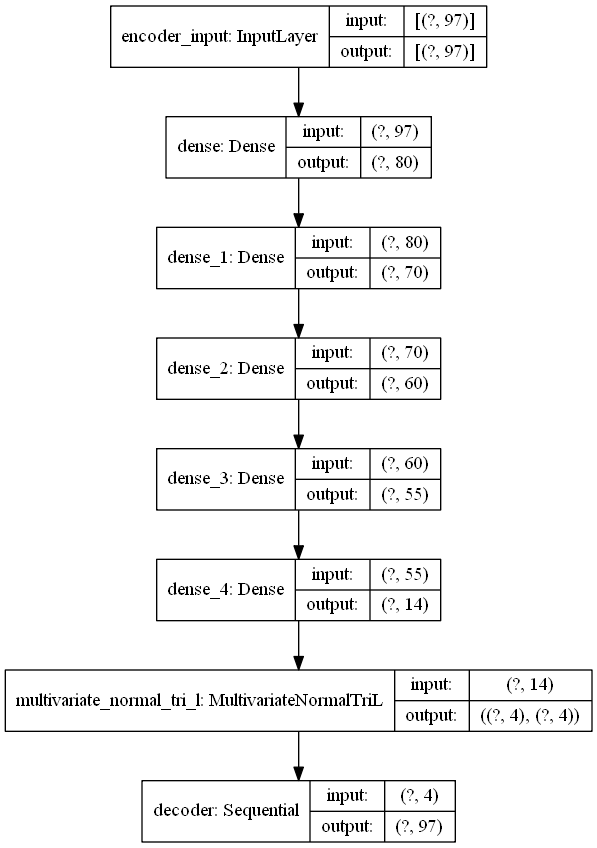

In [7]:
# def dense_layers(sizes):
#     return tfk.Sequential([tfkl.Dense(size, activation=tf.nn.leaky_relu) for size in sizes])
# intermediary_dims = [25, 20, 15, 10, 8]

original_dim = X.shape[1]
input_shape = X[0].shape
latent_dim = 4
batch_size = 64
max_epochs = 80

prior = tfd.MultivariateNormalDiag(loc=tf.zeros([latent_dim]), scale_identity_multiplier=1.0)

encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape, name='encoder_input'),
    tfkl.Dense(80, activation='relu'),
    tfkl.Dense(70, activation='relu'),
    tfkl.Dense(60, activation='relu'),
    tfkl.Dense(55, activation='relu'),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),
    tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),], name='encoder')


encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[latent_dim]),
    tfkl.Dense(55, activation='relu'),
    tfkl.Dense(60, activation='relu'),
    tfkl.Dense(70, activation='relu'),
    tfkl.Dense(80, activation='relu'),
    tfkl.Dense(tfpl.IndependentNormal.params_size(original_dim), activation=None), 
    tfpl.IndependentNormal(original_dim),], name='decoder')

decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

vae = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]), name='vae_mlp')

negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.keras.optimizers.Nadam(), loss=negloglik, metrics=['accuracy'])

vae.summary()

plot_model(vae, to_file='vae_mlp.png', show_shapes=True)

In [8]:
x = df.drop(["OUTCOME"], axis=1)
y = df["OUTCOME"].values

x_norm, x_fraud = x.values[y == 0], x.values[y == 1]

x_norm_sample = x_norm[np.random.randint(x_norm.shape[0], size=100000), :]
x_norm_train_sample, x_norm_val_sample = train_test_split(x_norm_sample, test_size=0.2)

In [9]:
print(x_norm.shape)
print(x_fraud.shape)
print(x_norm_sample.shape)
print(x_norm_train_sample.shape)
print(x_norm_val_sample.shape)

(162824, 97)
(9977, 97)
(100000, 97)
(80000, 97)
(20000, 97)


In [ ]:
batch_size = 64
max_epochs = 50

In [ ]:
tf_train = tf.data.Dataset.from_tensor_slices(
    (x_norm_train_sample, x_norm_train_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))

tf_val = tf.data.Dataset.from_tensor_slices(
    (x_norm_val_sample, x_norm_val_sample)).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE).shuffle(int(10e4))

In [10]:
# batch_size = 16
# max_epochs = 10

checkpointer = ModelCheckpoint(filepath='bestmodel.h5', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.005, patience=20, verbose=0, restore_best_weights=True)

hist = vae.fit(x_norm_train_sample, x_norm_train_sample, epochs=max_epochs, shuffle=True, verbose=1,
               validation_data=(x_norm_val_sample, x_norm_val_sample), callbacks=[checkpointer, earlystopper])

plot_loss(hist)

Epoch 1/80
2260/2500 [==========================>...] - ETA: 1s - loss: 71.0694 - accuracy: 0.0393

KeyboardInterrupt: 

In [ ]:
reconstruct_samples_n = 100

def reconstruction_log_prob(eval_samples, reconstruct_samples_n):
    encoder_out = encoder(eval_samples)
    encoder_samples = encoder_out.sample(reconstruct_samples_n)
    return np.mean(decoder(encoder_samples).log_prob(eval_samples), axis=0)

In [ ]:
latent_x_mean = encoder(X).mean()
plt.scatter(latent_x_mean[:, 0], latent_x_mean[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent means')
plt.ylabel('mean[1]')
plt.xlabel('mean[0]')
plt.show()
# tsne_plot(latent_x_mean, data_sample["Class"].values, "raw.png")

In [ ]:
latent_x_std = encoder(X).stddev()
plt.scatter(latent_x_std[:, 0], latent_x_std[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent standard deviations')
plt.ylabel('stddev[1]')
plt.xlabel('stddev[0]')
plt.show()

In [ ]:
latent_x = encoder(X).sample()
plt.scatter(latent_x[:, 0], latent_x[:, 1], c=Y, cmap='RdYlGn_r', s=2)
plt.title('latent vector samples')
plt.ylabel('z[1]')
plt.xlabel('z[0]')
plt.show()

In [ ]:
x_log_prob = reconstruction_log_prob(X, reconstruct_samples_n)
ax = plt.hist([x_log_prob[Y==0], x_log_prob[Y==1]], 97)
plt.title('reconstruction log probability')
plt.ylabel('frequency')
plt.xlabel("log p(x|x')")
plt.show()

In [ ]:
fpr, tpr, thresh = roc_curve(Y, -x_log_prob)
auc = roc_auc_score(Y, -x_log_prob)

plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('VAE roc curve - training')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

In [ ]:
x_test_log_prob = reconstruction_log_prob(data_test.drop(['OUTCOME'], axis = 1).values, reconstruct_samples_n)
test_y = data_test["OUTCOME"].values

fpr, tpr, thresh = roc_curve(test_y, -x_test_log_prob)
auc = roc_auc_score(test_y, -x_test_log_prob)

plt.plot(fpr,tpr,label="linear in-sample, auc="+str(auc))
plt.title('VAE roc curve - test')
plt.ylabel('True Positive Rate')
plt.xlabel("False Positive Rate")
plt.legend(loc='best')
plt.show()

In [ ]:
# def dense_layers(sizes):
#     return tfk.Sequential([tfkl.Dense(size, activation=tf.nn.relu) for size in sizes])

original_dim = X_train.shape[1]
input_shape = X_train.shape[1]
# intermediary_dims = [75, 60, 50]
latent_dim = 2
batch_size = 128
max_epochs = 30

# prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_dim), scale=1), reinterpreted_batch_ndims=1)

prior = tfd.MultivariateNormalDiag(loc=tf.zeros([latent_dim]), scale_identity_multiplier=1.0)

encoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=input_shape, name='encoder_input'),
    tfkl.Dense(75, activation=tf.nn.relu),
    tfkl.Dense(60, activation=tf.nn.relu),
    tfkl.Dense(50, activation=tf.nn.relu),
#    dense_layers(intermediary_dims),
    tfkl.Dense(tfpl.MultivariateNormalTriL.params_size(latent_dim), activation=None),
    tfpl.MultivariateNormalTriL(latent_dim, activity_regularizer=tfpl.KLDivergenceRegularizer(prior)),], name='encoder')

encoder.summary()
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

decoder = tfk.Sequential([
    tfkl.InputLayer(input_shape=[latent_dim]),
    tfkl.Dense(50, activation=tf.nn.relu),
    tfkl.Dense(60, activation=tf.nn.relu),
    tfkl.Dense(75, activation=tf.nn.relu),
#    dense_layers(reversed(intermediary_dims)),
    tfkl.Dense(tfpl.IndependentNormal.params_size(original_dim), activation=None), 
    tfpl.IndependentNormal(original_dim),], name='decoder')

decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

vae = tfk.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs[0]), name='vae_mlp')

negloglik = lambda x, rv_x: -rv_x.log_prob(x)

vae.compile(optimizer=tf.keras.optimizers.Nadam(), loss=negloglik, metrics=['accuracy'])

vae.summary()
plot_model(vae, to_file='vae_mlp.png', show_shapes=True)